This notebook computes the learning outcomes from the pre-test and post-test responses.

We consider two learning goals:
* LG1: identify a (feasible) solution to the problem
* LG2: construct a correct (i.e. optimal) solution.
    
For LG1, we check connectedness, i.e. if solutions are spanning or not
out.

For LG2, we check optimality, i.e. how close was the solution to the correct solution, quantified by the error.

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import wilcoxon, shapiro, ttest_rel
from effsize.effsize import two_group_difference

In [2]:
sns.set_context('paper', font_scale=1.5)

### Define paths.

In [3]:
transition_tables_pickle_file = pl.Path(
    '../processed_data/justhink_spring21_transition_tables.pickle')

learning_pickle_file = pl.Path(
    '../processed_data/learning_table.pickle')

figs_dir = pl.Path('../figures')

In [4]:
test_item_counts = {
    'pretest': 5,
    'posttest': 5,
}

### Load transition tables.

In [5]:
with transition_tables_pickle_file.open('rb') as handle:
    transition_tables = pickle.load(handle)
    
# transition_tables.keys()
# pd.options.display.max_rows = None
# transition_tables[10]

<!-- ### Cleaning tables. -->

### Fiter for the submissions.

In [6]:
def filter_submissions(transition_tables, verbose=False):
    """Get the submission states only, and drop the duplicates, 
    unused columns, keep state, activity, imported info."""
    tables = {}

    for participant in sorted(transition_tables):
        print('Filtering submissions for {}...'.format(participant))

        df = transition_tables[participant].copy()

        # Filter for the submission rows.
        df = df[df['is_submission']]

        # Remove duplicate rows from submission log and keeping the last submission
        df.drop_duplicates(subset='activity', keep='last', inplace=True)

        tables[participant] = df

        if verbose:
            display(df)

    print('Done!')

    return tables


submission_tables = filter_submissions(transition_tables)

# submission_tables[8]

Filtering submissions for 1...
Filtering submissions for 2...
Filtering submissions for 3...
Filtering submissions for 4...
Filtering submissions for 5...
Filtering submissions for 6...
Filtering submissions for 7...
Filtering submissions for 8...
Filtering submissions for 9...
Done!


### Count feasible and optimal solutions in the tests.

In [7]:
def count_feasible(df, test_name):
    """Count the number of feasible solutions given to a 
    pre-test or post-test."""
    count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            if row['is_spanning']:
                count = count + 1
    return count


def score_feasible(df, test_name, total_count):
    return count_feasible(df, test_name) / total_count


for participant, df in submission_tables.items():
    print('{:2.0f}: feasible scores: pre-test {}, post-test {}'.format(
        participant,
        score_feasible(df, 'pretest', test_item_counts['pretest']),
        score_feasible(df, 'posttest', test_item_counts['posttest'])))

 1: feasible scores: pre-test 1.0, post-test 1.0
 2: feasible scores: pre-test 0.8, post-test 1.0
 3: feasible scores: pre-test 1.0, post-test 1.0
 4: feasible scores: pre-test 0.8, post-test 1.0
 5: feasible scores: pre-test 1.0, post-test 0.8
 6: feasible scores: pre-test 1.0, post-test 0.8
 7: feasible scores: pre-test 0.4, post-test 0.0
 8: feasible scores: pre-test 1.0, post-test 1.0
 9: feasible scores: pre-test 1.0, post-test 1.0


In [8]:
def count_optimal(df, test_name):
    """Count the number of optimal solutions given to a 
    pre-test or post-test."""
    count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            if row['is_mst']:
                count = count + 1
    return count


def score_optimal(df, test_name, total_count):
    return count_optimal(df, test_name) / total_count


for participant, df in submission_tables.items():
    print('{:2.0f}: optimal scores: pre-test {}, post-test {}'.format(
        participant,
        score_optimal(df, 'pretest', test_item_counts['pretest']),
        score_optimal(df, 'posttest', test_item_counts['posttest'])))

 1: optimal scores: pre-test 0.4, post-test 0.8
 2: optimal scores: pre-test 0.0, post-test 0.8
 3: optimal scores: pre-test 0.2, post-test 1.0
 4: optimal scores: pre-test 0.0, post-test 0.0
 5: optimal scores: pre-test 0.0, post-test 0.0
 6: optimal scores: pre-test 0.0, post-test 0.0
 7: optimal scores: pre-test 0.2, post-test 0.0
 8: optimal scores: pre-test 0.0, post-test 0.0
 9: optimal scores: pre-test 0.8, post-test 0.8


### Compute average error in the tests.

In [9]:
def compute_average_error(df, test_name, total_count):
    """Compute average error for a test."""
    total_error = 0
    count = 0
    for index, row in df.iterrows():
        error = row['error']
        if test_name in row['activity']:
            # not computing the error for submissions that are not feasible/spanning
            count = count + 1
            if not math.isnan(error):
                total_error = total_error + error

    # Validity check.
    if count != total_count:
        print('Log of {} does not match with the number of items in {}'.format(
            participant, test_name))
        print(count, total_count)
        raise ValueError

    # compute averages while handling zero division
    if count != 0:
        average_error = total_error / total_count
    else:
        average_error = None
    return average_error


for participant, df in submission_tables.items():
    print('{:2.0f}: average errors: pre-test {}, post-test {}'.format(
        participant,
        compute_average_error(df, 'pretest', test_item_counts['pretest']),
        compute_average_error(df, 'posttest', test_item_counts['posttest'])))

 1: average errors: pre-test 0.16952380952380955, post-test 0.013333333333333332
 2: average errors: pre-test 0.31047619047619046, post-test 0.009523809523809523
 3: average errors: pre-test 0.040634920634920635, post-test 0.0
 4: average errors: pre-test 0.3898412698412698, post-test 0.3555555555555555
 5: average errors: pre-test 0.3003174603174603, post-test 0.16698412698412696
 6: average errors: pre-test 0.30984126984126986, post-test 0.14984126984126983
 7: average errors: pre-test 0.04, post-test 0.0
 8: average errors: pre-test 0.9257142857142858, post-test 0.1034920634920635
 9: average errors: pre-test 0.013333333333333332, post-test 0.009523809523809523


### Make a learning outcomes table.

In [10]:
participants = list(submission_tables.keys())

learn_df = pd.DataFrame(index=participants)
learn_df.index.name = 'participant'
for test in ['pretest', 'posttest']:
    count = test_item_counts[test]
    learn_df['{}_feasible'.format(test)] = \
        [score_feasible(submission_tables[p], test,count ) for p in participants]
    learn_df['{}_optimal'.format(test)] = \
        [score_optimal(submission_tables[p], test, count) for p in participants]
    learn_df['{}_error'.format(test)] = \
        [compute_average_error(submission_tables[p], test, count) for p in participants]
    
learn_df

,pretest_feasible,pretest_optimal,pretest_error,posttest_feasible,posttest_optimal,posttest_error
participant,,,,,,
1,1.0,0.4,0.169524,1.0,0.8,0.013333
2,0.8,0.0,0.310476,1.0,0.8,0.009524
3,1.0,0.2,0.040635,1.0,1.0,0.000000
4,0.8,0.0,0.389841,1.0,0.0,0.355556
5,1.0,0.0,0.300317,0.8,0.0,0.166984
6,1.0,0.0,0.309841,0.8,0.0,0.149841
7,0.4,0.2,0.040000,0.0,0.0,0.000000
8,1.0,0.0,0.925714,1.0,0.0,0.103492
9,1.0,0.8,0.013333,1.0,0.8,0.009524


In [11]:
# ### Reshape learng for visualization.
# # reformatting is_spanning and is_mst dataframes for visualization
# span_learning_df = learn_df[['participant', 'pretest_span', 'posttest_span']]
# mst_learning_df = learn_df[['participant', 'pretest_mst', 'posttest_mst']]
# error_learning_df = learn_df[['participant', 'pre_error', 'post_error']]

# spandf = pd.DataFrame(np.repeat(span_learning_df.values, 2, axis=0))
# spandf.columns = span_learning_df.columns

# mstdf = pd.DataFrame(np.repeat(mst_learning_df.values, 2, axis=0))
# mstdf.columns = mst_learning_df.columns

# errordf = pd.DataFrame(np.repeat(error_learning_df.values, 2, axis=0))
# errordf.columns = error_learning_df.columns

# # reformatting spanning dataframe
# p_type = list()
# value = list()
# for index, row in spandf.iterrows():
#     if index % 2 == 0:
#         p_type.append('pretest')
#         value.append(row['pretest_span'])
#     else:
#         p_type.append('posttest')
#         value.append(row['posttest_span'])
# spandf['p_type'] = p_type
# spandf['value'] = value

# # reformatting mst dataframe
# mst_value = list()
# for index, row in mstdf.iterrows():
#     if index % 2 == 0:
#         mst_value.append(row['pretest_mst'])
#     else:
#         mst_value.append(row['posttest_mst'])
# mstdf['p_type'] = p_type
# mstdf['value'] = mst_value

# # reformatting error dataframe
# error_value = list()
# for index, row in errordf.iterrows():
#     if index % 2 == 0:
#         error_value.append(row['pre_error'])
#     else:
#         error_value.append(row['post_error'])
# errordf['p_type'] = p_type
# errordf['value'] = error_value


# spandf.drop(columns=['pretest_span', 'posttest_span'], inplace=True)
# mstdf.drop(columns=['pretest_mst', 'posttest_mst'], inplace=True)
# errordf.drop(columns=['pre_error', 'post_error'], inplace=True)

# display(spandf)
# display(mstdf)
# display(errordf)

In [12]:
# ### Reshape collaborative activity table.
# # formatting dataframe for collab activities
# cdf = pd.DataFrame()

# for key, mdf in all_tables.items():
#     collab_df = mdf.loc[mdf['header.frame_id'].isin(
#         ['collab-activity', 'collab-activity-2'])].copy()
#     collab_df['participant'] = key
#     collab_df.drop(columns=['action.agent_name', 'state', 'is_submission',
#                    'cost', 'mst_cost', 'spanning', 'error'], inplace=True)
#     collab_df.rename(columns={"header.frame_id": "activity"}, inplace=True)
#     cdf = cdf.append(collab_df)

# cdf.sort_values(by=['participant'], inplace=True)
# values = list()
# for index, row in cdf.iterrows():
#     if row['is_mst'] == True:
#         values.append(1)
#     else:
#         values.append(0)
# cdf['is_mst'] = values
# cdf

In [13]:
# ### Visualize collaborative activity performance.

# participants = [1, 2, 3, 4, 5, 6, 7, 9, 10]
# separation = 0.01

# # graphing the pretest versus posttest is_spanning scores
# fig, ax = plt.subplots(1, figsize=(5, 5))

# prelist = list()
# postlist = list()
# for i in participants:
#     temp = cdf[cdf['participant'] == i]
#     values = list(temp.is_mst)
#     #computing offset between overlapping lines
#     p0 = values[0] + prelist.count(values[0])*separation
#     p1 = values[1] + prelist.count(values[1])*separation
#     prelist.append(values[0])
#     postlist.append(values[1])
#     #plotting
#     plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
# plt.ylabel('Score')
# plt.title('Collab Activity Success\n', loc='center', fontsize=20)

# leg = plt.legend(participants, loc='upper left', frameon=True)
# # get the bounding box of the original legend
# bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# # change to location of the legend
# xOffset = 1.1
# bb.x0 += xOffset
# bb.x1 += xOffset
# leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# # set y axis ticks to percentages
# yticks = plt.yticks()[0]
# plt.yticks(np.arange(0, 2, step=1), ['Fail','Success'])
# plt.show()

### Visualize feasible solutions in the tests.

2 (0.8, 1.0) 0.78 0.98
4 (0.8, 1.0) 0.79 0.99
5 (1.0, 0.8) 0.98 0.78
6 (1.0, 0.8) 0.99 0.79
7 (0.4, 0.0) 0.38 -0.02
1 (1.0, 1.0) 1.0 1.0
3 (1.0, 1.0) 1.01 1.01
8 (1.0, 1.0) 1.02 1.02
9 (1.0, 1.0) 1.03 1.03
../figures/learning_outcomes_feasible.pdf


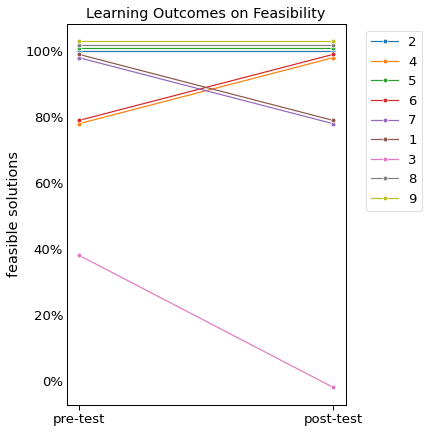

In [56]:
# participants = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01
participants = learn_df.index

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 7))

participants = [2, 4, 5, 6, 7, 1, 3, 8, 9]
# Positions.
prelist = list()
postlist = list()
positions = dict()
for participant in participants:  # participants:  #reversed():
    temp = learn_df.loc[participant]  # learn_df[learn_df['participant'] == i]
    values = temp.pretest_feasible, temp.posttest_feasible
    # Compute offset to prevent overlapping lines.
    p0 = values[0] + (prelist.count(values[0])-2)*separation
    p1 = values[1] + (postlist.count(values[1])-2)*separation
    prelist.append(values[0])
    postlist.append(values[1])
    print(participant, values, p0, p1)
    positions[participant] = (p0, p1)

# Plot.
for participant in sorted(participants):
    position = positions[participant]
    # Plot a line segment for the participant.
    sns.lineplot(
        x=['pre-test', 'post-test'], y=position,
        marker='o', label=str(participant),
        legend=False, ax=ax)

ax.set_ylabel('feasible solutions')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.xaxis.tick_params(length=0)
ax.tick_params(axis='y', which='both', length=0)

ax.set_title('Learning Outcomes on Feasibility')

# fig.legend(borderpad=0.2)
leg = plt.legend(participants, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.05  # 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

export_file = figs_dir.joinpath('learning_outcomes_feasible.pdf')
fig.savefig(export_file, bbox_inches='tight')
print(export_file)

### Visualize feasible solutions in the tests.

In [57]:
# # graphing the pretest versus posttest is_mst scores
# fig, ax = plt.subplots(1, figsize=(5, 7))

# prelist = list()
# postlist = list()
# for i in participants:
#     temp = mstdf[mstdf['participant'] == i]
#     values = list(temp.value)
#     #computing offset between overlapping lines
#     p0 = values[0] + prelist.count(values[0])*separation
#     p1 = values[1] + prelist.count(values[1])*separation
#     prelist.append(values[0])
#     postlist.append(values[1])
#     #plotting
#     plt.plot(temp.p_type, [p0,p1], marker='o', markersize=5)
# plt.ylabel('Score')
# plt.title('Optimal Solution\n', loc='center', fontsize=20)

# leg = plt.legend(participants, loc='upper left', frameon=True)
# # get the bounding box of the original legend
# bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# # change to location of the legend
# xOffset = 1.1
# bb.x0 += xOffset
# bb.x1 += xOffset
# leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# # set y axis ticks to percentages
# yticks = plt.yticks()[0]
# plt.yticks(yticks[1:-1], [str(round((i/5)*100)) + '%' for i in yticks[1:-1]])
# plt.show()

# # graphing the pretest versus posttest spanning scores
# fig, ax = plt.subplots(1, figsize=(5, 7))
# for i in participants:
#     temp = errordf[errordf['participant'] == i]
#     plt.plot(temp.p_type, temp.value, marker='o', markersize=5)
# plt.ylabel('Score')
# plt.title('Error Average\n', loc='center', fontsize=20)

# leg = plt.legend(participants, loc='upper left', frameon=True)
# # get the bounding box of the original legend
# bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# # change to location of the legend
# xOffset = 1.1
# bb.x0 += xOffset
# bb.x1 += xOffset
# leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# # set y axis ticks to percentages
# yticks = plt.yticks()[0]
# plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
# plt.show()

### Perform Wilcoxon signed-rank test.

In [ ]:
df = learning_df.copy()
df.rename(columns={"pre_error": "pretest_error", "post_error":"posttest_error"}, inplace=True)
display(df)
df.dropna(inplace=True)

categories = ['span','mst', 'error']

for name in categories:
    r = list(df['pretest_' + name])
    o = list(df['posttest_' + name])
    print(name)
    w, p = wilcoxon(r,o,mode="exact") 
    #null hypotehsis says they are the same, p val less than threshold, reject hyp, conclude that post is larger than pretest
    print('Exact:','W=',w,'pvalue=',p)
    a,b = wilcoxon(r,o,mode="exact", alternative="greater")
    print('Greater:','W=',a,'pvalue=',b)

# display(learning_df)

In [ ]:
with learning_pickle_file.open('wb') as handle:
    pickle.dump(learn_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved learning table to {}'.format(learning_pickle_file))

### Compute the effect size (estimated by Cliff's delta).

In [ ]:
categories = ['span', 'mst', 'error']

for name in categories:
    r = list(df['pretest_{}'.format(name)])
    o = list(df['posttest_{}'.format(name)])
    print(name)
    
    # Estimate effect size by Cliff's Delta.
    d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
    print("For categury {} Cliff's delta = {}".format(name, d)